Estrelinizador
=============
Convolve um espalhador com um refletor

---

In [4]:
!git clone https://github.com/hpg-cepetro/pymei.git
!ls

Cloning into 'pymei'...
remote: Enumerating objects: 129, done.
remote: Total 129 (delta 0), reused 0 (delta 0), pack-reused 129
Receiving objects: 100% (129/129), 23.35 KiB | 0 bytes/s, done.
Resolving deltas: 100% (58/58), done.
Checking connectivity... done.
Estrelinizador.ipynb  jequitinhonha_migrado.su	pymei  utils.py  utils.pyc


In [1]:
from __future__ import print_function
import numpy as np
from scipy.signal import convolve2d

# Importa bibliotecas próprias
from utils import * 

# Configura o matplolib para plotar inline
# %matplotlib qt5
%matplotlib notebook

Visualiza dado. Botão esquerdo imprime pick com evento=1.0 e botão direito com evento=0.0

Carregando o empilhamento ./jequitinhonha_migrado.su
2079 traços:
 - CDP: [2 - 2080]
 - Amostras por traço (ns): 876
 - Tempo entre amostras (dt): 4.0 ms
Dimensões do dado 1: (876, 2079)

Tamanho da imagem (em polegadas): 28.88 x 12.17
Coordenadas:  x - [2.0, 2081.0], y - [0.0, 3.5]
Dimensão: (876, 2079)



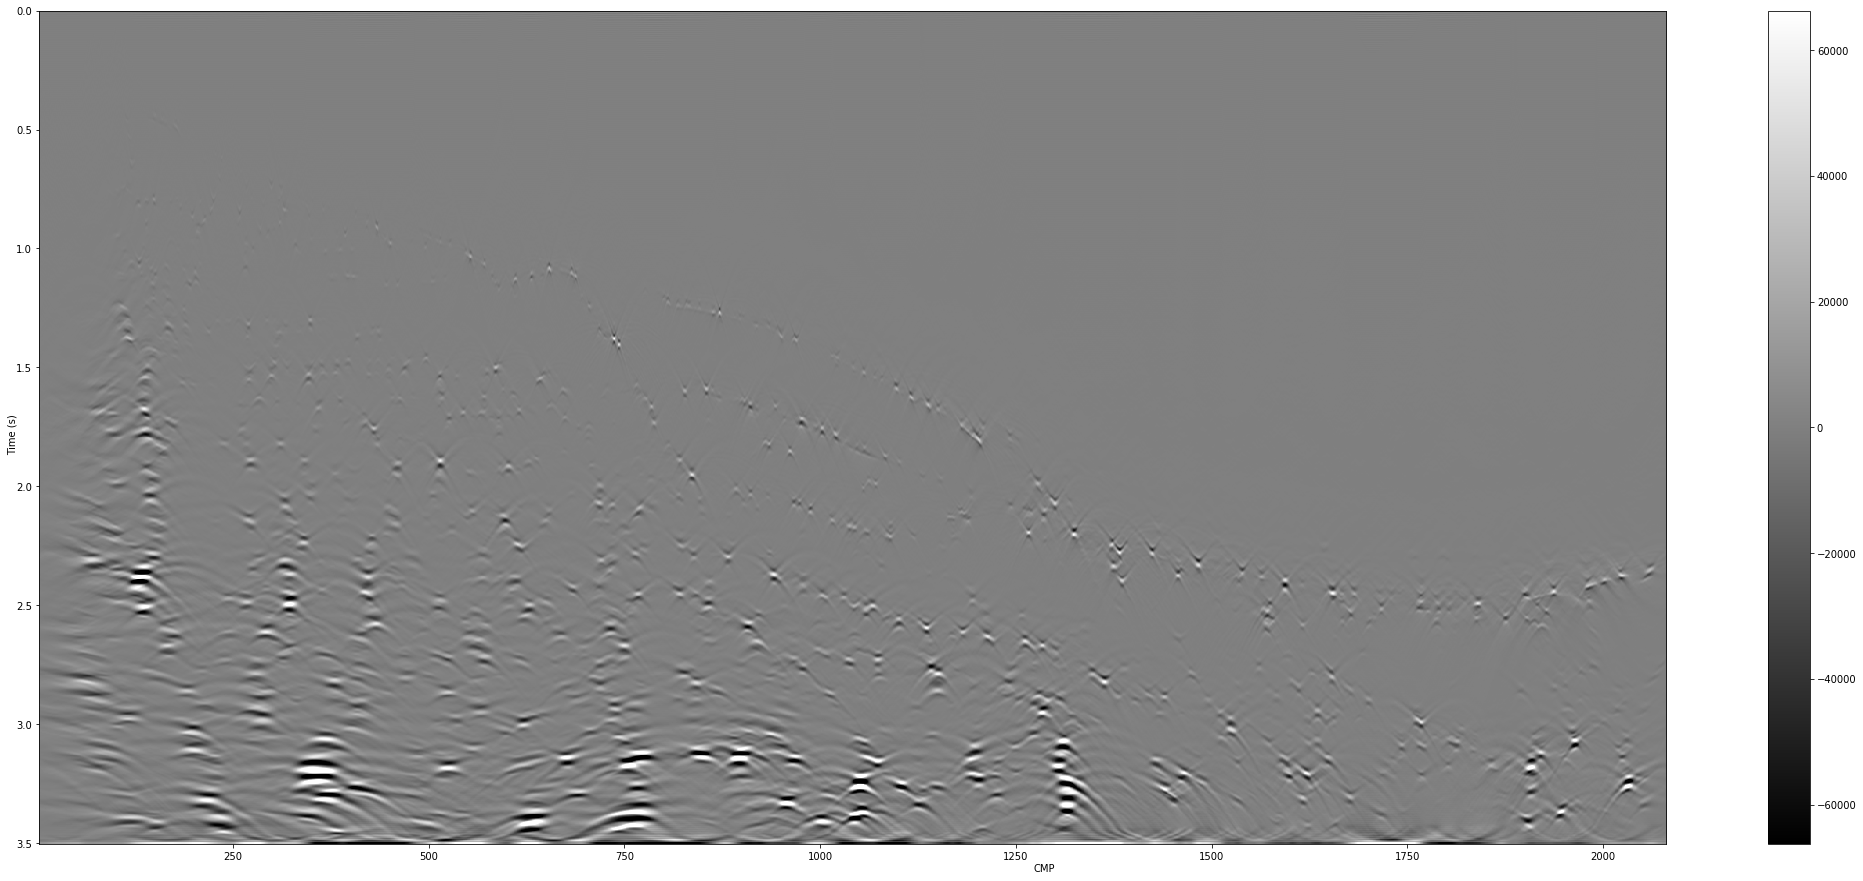

In [2]:
# Definição de arquivos de entrada
stack_file = './jequitinhonha_migrado.su'

color = 'gray'
plot_bar = True
clip = 0.3

# Carrega dados
if not stack_file is None: 
    traces = load_traces(stack_file)
    stack_image = get_data_from_traces(traces)
    print("Dimensões do dado 1:", stack_image.shape)
    print()

multiple_event_viewer(stack_image,
             cdp_offset=traces[0].cdp, dt=traces[0].dt,
             clip_percent1=clip, color1=color)

Converte coordenada de em (cdp, tempo) para índices da matriz

In [3]:
coord = 'evento=0.0, cdp=835.555810, tempo=1.950138'

time_ind = coord.find('tempo=')
time = float(coord[time_ind+6:])
cdp = np.floor(float(coord[coord.find('cdp=')+4:time_ind-2]))
pick_coords = picks_to_index([(cdp, time)], traces)
print("cdp:", cdp, "tempo:", time)
print("picks:", pick_coords)

cdp: 835.0 tempo: 1.950138
picks: [[487, 833]]


Gera função de _taper_

[0.97552824 0.9045085  0.7938926  0.6545085  0.49999997 0.34549147
 0.20610741 0.09549147 0.0244717  0.        ]


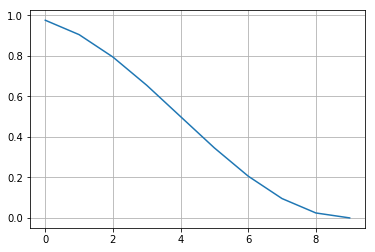

In [4]:
import matplotlib.pyplot as plt

taper_size = 10

taper = (np.pi / (taper_size)) * (np.arange(taper_size).astype(np.float32) + 1.0)
taper = (np.cos(taper) / 2.0) + 0.5
print(taper)

plt.plot(range(taper_size), taper)
plt.grid()

plt.show()

Gerar espalhador com _taper_

Espelhamento das amostras (flip): False
Tamanho da imagem (em polegadas): 7.08 x 7.08
Coordenadas:  x - [0.0, 51.0], y - [0.0, 51.0]
Dimensão: (51, 51)



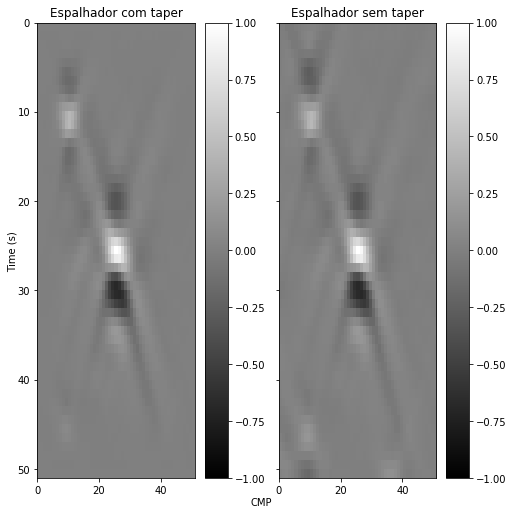

In [6]:
# Define tamanho da janela ao redor do espalhador
window_size = 31

color = 'gray'
resize = 10.0

scatter = generate_samples(stack_image, window_size+2*taper_size, pick_coords, flip=False)[0][0]

#Normaliza o espalhador
vmax = np.max(np.abs((scatter.max(), scatter.min())))
scatter = scatter / vmax
original = scatter.copy()

taper = taper.reshape((1,taper_size))

right_taper = taper
left_taper = np.flip(taper)
top_taper = left_taper.T
bottom_taper = right_taper.T

# Taper superior
scatter[0:taper_size, :] *= top_taper
# Taper inferior
scatter[(scatter.shape[0] - taper_size):, :] *= bottom_taper
# Taper esquerdo
scatter[:, 0:taper_size] *= left_taper
# Taper direito
scatter[:, (scatter.shape[0] - taper_size):] *= right_taper


title1 = 'Espalhador com taper'
title2 = 'Espalhador sem taper'

multiple_event_viewer(scatter, original,
                      resize=resize, color1=color, color2=color,
                     title1=title1, title2=title2)

Extrai frequencia do espalhador. Baseado na equação apresentada em http://subsurfwiki.org/wiki/Ricker_wavelet 

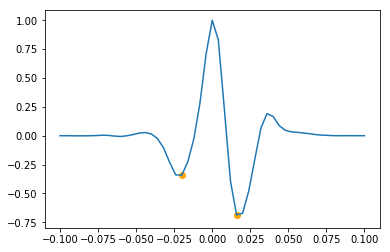

Freq. lóbulo esquerdo: 19.4924200308419
Freq. lóbulo direito: 24.365525038552377


In [7]:
center = scatter.shape[0] / 2
dt = traces[0].dt 

center_trace = scatter[:,center]
left_lobe = center_trace[0:center].min()
right_lobe = center_trace[center:].min()

left_time = np.where(center_trace == left_lobe)[0][0] * dt - (center*dt)
right_time = np.where(center_trace == right_lobe)[0][0] * dt - (center*dt)

time_axis = np.arange(scatter.shape[0], dtype=np.float32) * dt - (center*dt)

plt.plot(time_axis, center_trace)
plt.scatter([left_time, right_time], [left_lobe, right_lobe], color='orange')

plt.show()

left_freq = np.abs(np.sqrt(1.5) / (np.pi * left_time))
right_freq = np.abs(np.sqrt(1.5) / (np.pi * right_time))

print("Freq. lóbulo esquerdo:", left_freq)
print("Freq. lóbulo direito:", right_freq)


Computa Ricker com as frequências extraídas

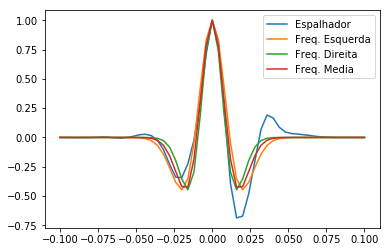

In [8]:
def ricker_wavelet(times, frequency):
    """
    Computa a Ricker Wavelet para os tempos e frequência da entrada.
    
    Args:
        times: vetor com os tempos a serem computados.
        frequency: frequência da wavelet.
        
    Retorno:
        wavelet: vetor de amplitudes da wavelet para cada ponto
    """
    cte = -(np.pi**2)*(frequency**2)
    exp = np.exp(cte*(times**2))
    wavelet = exp + 2*cte*(times**2)*exp
    return wavelet

left_wavelet = ricker_wavelet(time_axis, left_freq)
right_wavelet = ricker_wavelet(time_axis, right_freq)
avg_wavelet = ricker_wavelet(time_axis, (left_freq+right_freq)/2)

plt.plot(time_axis, center_trace, label="Espalhador")
plt.plot(time_axis, left_wavelet, label="Freq. Esquerda")
plt.plot(time_axis, right_wavelet, label="Freq. Direita")
plt.plot(time_axis, avg_wavelet, label="Freq. Media")
plt.legend()


plt.show()


Gerar dado sintético

Tamanho da imagem (em polegadas): 6.94 x 6.94
Coordenadas:  x - [0.0, 200.0], y - [0.0, 200.0]
Dimensão: (200, 200)



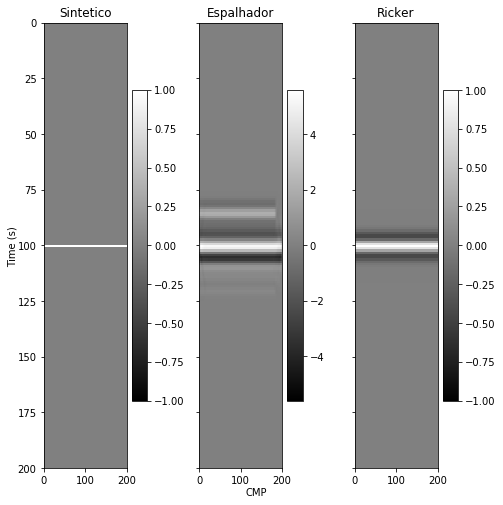

In [9]:
color = 'gray'
resize = 2.5

synthetic = np.zeros((200,200), dtype=np.float32)
synthetic[100,:] = 1.0

avg_wavelet = avg_wavelet.reshape((1,avg_wavelet.size)).T

synthetic_scatter = convolve2d(synthetic, scatter, mode='same')
synthetic_ricker = convolve2d(synthetic, avg_wavelet, mode='same')

title1 = 'Sintetico'
title2 = 'Espalhador'
title3 = 'Ricker'

multiple_event_viewer(synthetic, synthetic_scatter, synthetic_ricker,
                      resize=resize, color1=color, color2=color, color3=color,
                     title1=title1, title2=title2, title3=title3)